# Extracción y preprocesamiento de datos
## Extracción
### Librerías

In [2]:
from Bio import SeqIO
import os

In [14]:
# Definir las listas de codones de inicio y terminación
codon_inicio = ['AUG']
codon_terminacion = ['UAA', 'UAG', 'UGA']

# Función para transcribir ADN a ARNm y separarlo en tripletes
def transcribir_adn_a_arnm(seq):
    ARNm = seq.replace('T', 'U')  # Reemplaza T por U
    ARNm = [ARNm[i:i+3] for i in range(0, len(ARNm), 3)]  # Separar en tripletes
    return ARNm

# Función para extraer secuencias de ARNm con codones de inicio y terminación
def extraccion(codon_inicio, codon_terminacion, ARNm):
    hay_inicio = any(codon in ARNm for codon in codon_inicio)
    hay_terminacion = any(codon in ARNm for codon in codon_terminacion)
    
    # No hacer nada si no se encuentran los codones
    if not (hay_inicio and hay_terminacion):
        return  # Salir de la función sin hacer nada

# Directorio donde están los archivos FASTA
directorio = "raw"

# Procesar cada archivo FASTA en el directorio
for archivo_fasta in os.listdir(directorio):
    if archivo_fasta.endswith(".fasta"):
        ruta_archivo = os.path.join(directorio, archivo_fasta)
        
        # Leer el archivo FASTA
        for record in SeqIO.parse(ruta_archivo, "fasta"):
            # Obtener la secuencia de ADN
            secuencia_adn = str(record.seq)
            
            # Transcribir a ARNm
            ARNm = transcribir_adn_a_arnm(secuencia_adn)
            
            # Aplicar la función de extracción
            extraccion(codon_inicio, codon_terminacion, ARNm)


# Modelos de clasificación
### Librerías

In [4]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tabulate import tabulate


## Lectura de las secuencias de proteínas

In [5]:
# Función para cargar las secuencias de proteínas de los archivos FASTA
def load_protein_sequences(folder_path):
    sequences = []
    for file in os.listdir(folder_path):
        if file.endswith(".fasta") or file.endswith(".fa"):
            for record in SeqIO.parse(os.path.join(folder_path, file), "fasta"):
                sequences.append(str(record.seq))
    return sequences

# Carga las secuencias de la carpeta 'proteins'
folder_path = "proteins"
protein_sequences = load_protein_sequences(folder_path)

## Aplicar One-Hot Encoding para las proteínas

In [6]:
# Función para realizar One-Hot Encoding
def one_hot_encode(sequences):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # Aminoácidos estándar
    aa_to_index = {aa: idx for idx, aa in enumerate(amino_acids)}
    
    # Crear matriz de One-Hot Encoding
    one_hot_matrix = np.zeros((len(sequences), max(len(seq) for seq in sequences), len(amino_acids)), dtype=int)
    
    for i, seq in enumerate(sequences):
        for j, aa in enumerate(seq):
            if aa in aa_to_index:
                one_hot_matrix[i, j, aa_to_index[aa]] = 1
    
    return one_hot_matrix

# Aplica One-Hot Encoding
one_hot_encoded = one_hot_encode(protein_sequences)


## Aplicar K-means para obtener las etiquetas

c:\Users\Alcampo\anaconda3\envs\aa1\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Etiquetas de k-means: [0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 3 3 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


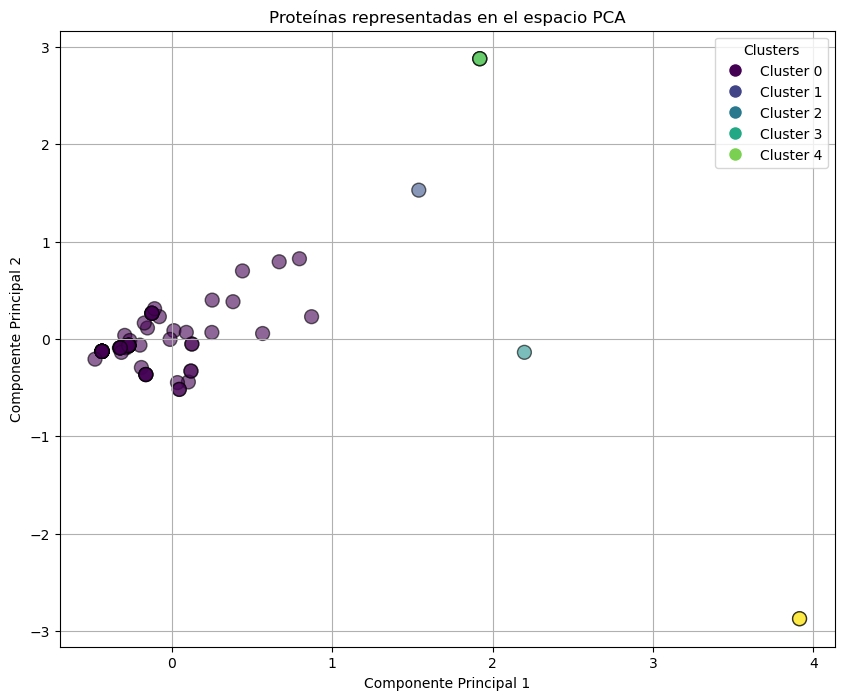

In [7]:
# Aplanar la matriz de One-Hot para aplicar k-means
n_samples, max_length, n_features = one_hot_encoded.shape
X = one_hot_encoded.reshape(n_samples, max_length * n_features)

# Aplicar k-means
n_clusters = 5  # Define el número de clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
labels = kmeans.fit_predict(X)

# Mostrar las etiquetas obtenidas
print("Etiquetas de k-means:", labels)

# Realizar PCA para reducir la dimensionalidad
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Crear un DataFrame para facilitar la visualización
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = labels

# Visualizar los resultados
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['Cluster'], cmap='viridis', alpha=0.6, edgecolor='k', s=100)
plt.title('Proteínas representadas en el espacio PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Añadir leyenda para los clusters
legend_labels = [f'Cluster {i}' for i in range(n_clusters)]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i/n_clusters), markersize=10) for i in range(n_clusters)]
plt.legend(handles, legend_labels, title='Clusters', loc='upper right')

plt.grid()
plt.show()

In [8]:
# Crear un DataFrame con las secuencias de proteínas y sus etiquetas de clúster
protein_df = pd.DataFrame({
    'Protein_Sequence': protein_sequences,
    'Cluster_Label': labels
})

# Mostrar el DataFrame
display(protein_df)

# Agrupar las proteínas por clúster y mostrar el resultado
clustered_proteins = protein_df.groupby('Cluster_Label')['Protein_Sequence'].apply(list)
print("\nProteínas por clúster:")
display(pd.DataFrame(clustered_proteins))

,Protein_Sequence,Cluster_Label
0,MVFLCMRPVFLFL,0
1,MEQPTSSTNGEKRKSPC,0
2,MGAGGVAAGR,0
3,MQLGAQLRCRTP,0
4,M,0
...,...,...
95,MALSFSLL,0
96,MAGRARRRQRRQRGRRF,0
97,M,0
98,MAL,0



Proteínas por clúster:


,Protein_Sequence
Cluster_Label,
0,"[MVFLCMRPVFLFL, MEQPTSSTNGEKRKSPC, MGAGGVAAGR,..."
1,[MAGRSLCLTRSSVPGTPFPPPVQQPSTPGPDLLALEEEY]
2,[MSGRRGPPVSSTGAPRSLGTPSPRAPRRRRC]
3,"[MAAVAAPHLSATAPGAV, MAAVAAPHLSATAPGAV, MAAVAAP..."
4,"[MVGLAPPFRGKPRAPGIARGSAPAPPDL, MVGLAPPFRGKPRAP..."


## Entrenamiento con los datos etiquetados

In [9]:
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Entrenar un modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Hacer predicciones
rf_predictions = rf_model.predict(X_test)

# Evaluar el modelo
rf_report = classification_report(y_test, rf_predictions, zero_division=1, output_dict=True)
rf_df = pd.DataFrame(rf_report).transpose()

print("Random Forest Classification Report:")
print(tabulate(rf_df, headers='keys', tablefmt='psql', floatfmt='.2f'))

# Entrenar un modelo SVM
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Hacer predicciones
svm_predictions = svm_model.predict(X_test)

# Evaluar el modelo
svm_report = classification_report(y_test, svm_predictions, zero_division=1, output_dict=True)
svm_df = pd.DataFrame(svm_report).transpose()

print("\nSVM Classification Report:")
print(tabulate(svm_df, headers='keys', tablefmt='psql', floatfmt='.2f'))


Random Forest Classification Report:
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     18.00 |
| 3            |        1.00 |     1.00 |       1.00 |      1.00 |
| 4            |        1.00 |     1.00 |       1.00 |      1.00 |
| accuracy     |        1.00 |     1.00 |       1.00 |      1.00 |
| macro avg    |        1.00 |     1.00 |       1.00 |     20.00 |
| weighted avg |        1.00 |     1.00 |       1.00 |     20.00 |
+--------------+-------------+----------+------------+-----------+

SVM Classification Report:
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 0            |        1.00 |     1.00 |       1.00 |     18.00